# [NTDS'17] assignment 3: solution
[ntds'17]: https://github.com/mdeff/ntds_2017

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](http://lts2.epfl.ch)

The first two assignments were designed to warm you up. This third assignment is closer to what we expect you to do for the projects. It mainly misses the exploratory data analysis part (though there is some in sections 5.1 and 5.2). As such, our plan for this assignement encompasses data collection and exploitation, and goes as follows:
1. Data collection: use a web API to collect the musical genre of 2000 songs.
2. Feature extraction: compute features from audio tracks.
3. Graph construction: construct a nearest-neighbor graph from the features.
4. Eigendecomposition: factorization of the graph Laplacian (c.f. spectral graph theory).
5. Visualization & Clustering: using the graph and eigenvectors to visualize the dataset and to cluster the tracks.
6. Conclusion: a reflexion about what we did (though realisations are scattered all along).

The data we are using for this assignment is a subset of the [Free Music Archive dataset](https://github.com/mdeff/fma), a collection of 1TB of music with metadata released under a permissive license.

In [1]:
%matplotlib inline

In [2]:
import configparser
import os

import requests
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import sparse, stats, spatial
import scipy.sparse.linalg
from sklearn import preprocessing, decomposition
import librosa
import IPython.display as ipd

In [3]:
plt.rcParams['figure.figsize'] = (17, 5)

If the above cell fails, it's most probably because you miss a package. Install them with e.g. `conda install tqdm librosa` (or `pip install tqdm librosa`).

## 1 Data collection

Like in any data project, the first part of the assignment is to collect some data. 

### 1.1 Get the genre of a single track

As often, we need an API key for certain operations. Add the following to your `credentials.ini` file. I gave a key during the lab on November 6. If you were not there, ask one of your classmates. Please do not over-use the key (it'll otherwise be banned for everybody).
```
[freemusicarchive]
api_key = MY-KEY
```

In [4]:
# Read the confidential API key.
credentials = configparser.ConfigParser()
credentials.read(os.path.join('..', 'credentials.ini'))
api_key = credentials.get('freemusicarchive', 'api_key')

Your first task is to develop a function to retrieve the genre ID of a track given its track ID using the [FMA API](https://freemusicarchive.org/api).

Hints:
* A track might have multiple genres associated to it. Always return the first one and discard the others.
    * Note: you should never discard data blindly. I selected the tracks so that this is not a problem.
* The `get_genre` function takes an integer as input, the track ID, and returns another integer, the genre ID.

In [5]:
def get_genre(track_id):
    """Returns the genre of a track by querying the API."""
    URL = 'https://freemusicarchive.org/api/get/tracks.json'
    params = {
        'track_id': track_id,
        'api_key': api_key,
    }
    response = requests.get(URL, params).json()
    return int(response['dataset'][0]['track_genres'][0]['genre_id'])

# A correct implementation should pass the below test.
assert get_genre(1219) == 38

### 1.2 Create a table of tracks

The `fma_tracks.csv` file contains a list of 2'000 track IDs that we will use through the assignment.

In [6]:
tracks = pd.read_csv('../data/fma_tracks.csv', index_col=0)
print('You got {} track IDs.'.format(len(tracks)))

You got 2000 track IDs.


Once imported by pandas, each row of the DataFrame represents a track. The index is the track ID and the genre column is the genre ID of each track.

In [7]:
tracks.iloc[125:130]

,genre
track_id,
11204,21
11264,88
11268,89
11298,21
11299,21


### 1.3 Add the genre to the table

The genre column contains an integer which represents the genre of the track, i.e. the return value of the `get_genre` function you developed. Because I'm a nice guy, I retrieved the genre for most tracks. Only the genre of the first 10 tracks is missing (zero is a placeholder value).

In [8]:
tracks.head(10)

,genre
track_id,
2,0
5,0
182,0
255,0
256,0
368,0
459,0
574,0
676,0


Your task is to replace the 10 zeros with the correct genre IDs.

Hints:
* As we want to apply one function (`get_genre`) to many data samples (the track IDs), you may want to use a functional approach. Check out `tracks.apply()` or the built-in `map`. In Python, you can declare an [anonymous function](https://en.wikipedia.org/wiki/Anonymous_function) as `lambda x: x + 1`.
* Your table should look like the above table, except with the correct number instead of zeros.

In [9]:
tracks['genre'][:10] = tracks[:10].index.map(get_genre)

# Alternative:
# tracks.iloc[:10, 0] = tracks[:10].apply(lambda track: get_genre(track.name), axis=1)

# Alternative:
# tracks.iloc[:10, 0] = list(map(get_genre, tracks.index[:10]))

### 1.4 Save the data

To avoid having to collect the data everytime you restart the IPython kernel, save the DataFrame as a CSV file.

In [10]:
tracks.to_csv('../data/fma_tracks_with_genre.csv')

You can now load it back with the following call instead of running the code in sections 1.1 to 1.3.

In [11]:
tracks = pd.read_csv('../data/fma_tracks_with_genre.csv', index_col=0)

### 1.5 Data cleaning

Data cleaning is necessary when dealing with real (as opposed to synthetic) data. In this case, we only need to "summarize the genres". The tracks I've selected for the assignment belong to either one of the following *top-level genres*: Rock (`genre_id=12`) and Hip-Hop (`genre_id=21`). There *actual genre(s)* might however be more specific and be a sub-genre of those. For example Punk is a sub-genre of Rock. You can explore the genre hierarchy on the [Free Music Archive](http://freemusicarchive.org/genre/Rock/). The below function will return the correct top-level genre for any of the sub-genres you'll encounter.

In [12]:
def get_top_genre(genre_id):
    if genre_id == 0:
        raise ValueError('Invalid genre! Please complete the DataFrame.')
    else:
        return 21 if genre_id in [21, 83, 100, 539, 542, 811] else 12

tracks = tracks.applymap(lambda genre: get_top_genre(genre))
tracks.head(4)

,genre
track_id,
2,21
5,21
182,12
255,12


If everything went fine, you should now have 1000 Rock (`genre_id=12`) and 1000 Hip-Hop (`genre_id=21`) tracks.

In [13]:
tracks['genre'].value_counts()

21    1000
12    1000
Name: genre, dtype: int64

## 2 Feature extraction

As is often the case, the data at hand is too large to be dealt with directly. We have to represent it with a smaller set of features, chosen to be maximally relevant to the task. (Manual feature extraction can sometimes be replaced by end-to-end learning systems.)

### 2.1 Get raw data

In the data folder, you'll find audio excerpts for the first 10 tracks listed in the `tracks` table. The audio is encoded as mp3 and the filename is simply the track ID.

[LibROSA](https://librosa.github.io/librosa/) is a well-designed Python package to deal with music data, i.e. to load audio, compute spectrograms and extract features. Let's use it and listen to some music. 

In [14]:
def get_path(track_id):
    return os.path.join('..', 'data', '{:06d}.mp3'.format(track_id))

# 1. Get the path to the first file.
filepath = get_path(tracks.index[0])
print('File: {}'.format(filepath))

# 2. Decode the mp3 and load the audio in memory.
audio, sampling_rate = librosa.load(filepath, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(audio.shape[-1] / sampling_rate, audio.size))

# 3. Load the audio in the browser and play it.
start, end = 7, 17
ipd.Audio(data=audio[start*sampling_rate:end*sampling_rate], rate=sampling_rate)

File: ../data/000002.mp3
Duration: 29.98s, 1321967 samples


If the above cell fails with a `NoBackendError`, it's most probably because you need an mp3 decoder that [audioread](https://github.com/beetbox/audioread) can call. Try to install ffmpeg with e.g. `conda install ffmpeg`.

### 2.2 Audio features

For music, the [mel-frequency cepstral coefficients (MFCCs)](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) are often relevant spectral features. Complete the implementation of the `compute_mfcc` function, which takes a track ID as its sole parameter and returns the coefficients.

Hint:
* Use the function `librosa.feature.mfcc` to compute those features.

In [15]:
N_MFCC = 20

def compute_mfcc(track_id):
    audio, sampling_rate = librosa.load(get_path(track_id), sr=None, mono=True)
    return librosa.feature.mfcc(y=audio, sr=sampling_rate, n_mfcc=N_MFCC)

mfcc = compute_mfcc(tracks.index[0])
assert mfcc.ndim == 2
assert mfcc.shape[0] == N_MFCC

### 2.3 Summary statistics

The `compute_mfcc` function we developed above computes `N_MFCC` coefficients per window in time. Notice that we computed `N_MFCC` x 2582 coefficients for the first track. To have a fixed representation for each complete track (and not for each window of 2048 samples), we need to aggregate those coefficients along time. We'll do it with 7 summary statistics: the minimum, the maximum, the median, and the first 4 moments, i.e. the mean, the standard deviation, the skew and the kurtosis.

Below, we construct the DataFrame that will hold our features. (Note the use of a hierarchical index.) Again, I computed the features for most tracks.

In [16]:
features = pd.read_csv('../data/fma_features.csv', index_col=0, header=[0, 1, 2])
assert (tracks.index == features.index).all()

features.tail(4)

features        mfcc                                                    \
statistics  kurtosis                                                     
number            01        02        03        04        05        06   
track_id                                                                 
154307     -0.120522  0.522564  0.772077 -0.631063 -0.439495 -0.579385   
154308      0.486471  2.039885  1.065340  1.553311  1.149207  1.233508   
154309     -0.000699 -0.664378  1.479098  0.647598  0.688074  1.628477   
155066      4.009223  2.374810  3.122061  0.323748  0.175242  0.158041   

features                                              ...                \
statistics                                            ...           std   
number            07        08        09        10    ...            11   
track_id                                              ...                 
154307     -0.435570 -0.253491 -0.057322 -0.178522    ...     11.143944   
154308      0.740646 -0.296303  0.002152  0.429307    ...      8.949037   
154309      0.819533 -0.440711 -0.458720 -0.618500    ...     11.229300   
155066      0.265011 -0.089093 -0.031688  0.431877    ...     11.405719   

features                                                                    \
statistics                                                                   
number             12         13         14         15        16        17   
track_id                                                                     
154307       9.791041   9.071079   9.473701   8.991920  8.465207  7.609439   
154308       6.971979   7.353863   7.962605   7.378716  7.031327  6.790538   
154309      11.016286   8.687562   8.560948   8.519457  7.922051  7.243402   
155066      10.899215  10.969735  11.738620  11.327765  9.786315  8.778796   

features                                   
statistics                                 
number            18         19        20  
track_id                                   
154307      8.693686  11.166705  9.853825  
154308      6.708085   7.647438  7.791453  
154309      7.598657   7.149076  8.686818  
155066      9.148952   8.944389  8.137584  

[4 rows x 140 columns]

Though I forgot to compute them for the first 10 tracks. ;-) Complete the below code to do that.

Hints:
* Functions to compute the mentioned statistics are found in `np` and `stats` (from `scipy`, see imports).
* We use `tqdm` to show progress on long computations. For example: `for i in tqdm(range(10)): print(i)`.

In [17]:
for tid in tqdm(tracks.index[:10]):
    mfcc = compute_mfcc(tid)
    features.at[tid, ('mfcc', 'mean')] = np.mean(mfcc, axis=1)
    features.at[tid, ('mfcc', 'std')] = np.std(mfcc, axis=1)
    features.at[tid, ('mfcc', 'skew')] = stats.skew(mfcc, axis=1)
    features.at[tid, ('mfcc', 'kurtosis')] = stats.kurtosis(mfcc, axis=1)
    features.at[tid, ('mfcc', 'median')] = np.median(mfcc, axis=1)
    features.at[tid, ('mfcc', 'min')] = np.min(mfcc, axis=1)
    features.at[tid, ('mfcc', 'max')] = np.max(mfcc, axis=1)

features['mfcc','mean'].head(4)

100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


number,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20
track_id,,,,,,,,,,,,,,,,,,,,
2,-122.712340,117.759397,-42.334596,38.060242,-23.011659,23.920413,-11.944656,13.687301,-7.294474,4.041134,-4.857005,-1.660614,-6.305957,-2.195009,1.731766,-0.433247,6.396583,-3.303581,1.283125,-5.927941
5,-162.232688,131.441883,-18.427922,51.634278,-15.447669,23.863670,-7.870194,10.688036,-0.314265,12.865315,-9.883394,0.066135,0.767982,2.769372,9.108076,1.641228,8.163592,-1.507941,1.992454,-4.972336
182,-109.799454,220.001599,-82.343022,31.680364,1.788921,-22.898936,25.879739,2.623440,2.484729,14.991756,7.680784,5.321623,10.864427,11.507535,3.471169,7.106788,6.655711,-2.040994,0.930488,2.027291
255,-207.437213,215.440329,-23.797856,20.623633,-5.739169,0.590755,6.398019,-3.267668,-2.143415,-4.535064,-3.603153,-3.754366,0.577303,-3.093996,-3.071847,-0.300081,-2.356464,-0.817920,-1.549295,-4.196416


### 2.4 Feature selection

Once you are done with the rest of the assignment and reach section 5.4, come back here and try to identify the most relevant features for our end goal, i.e. data visualization and clustering.

In [18]:
features.drop(('mfcc', 'kurtosis'), axis=1, inplace=True)
features.drop(('mfcc', 'skew'), axis=1, inplace=True)
features.drop(('mfcc', 'min'), axis=1, inplace=True)
features.drop(('mfcc', 'max'), axis=1, inplace=True)

### 2.5 Feature normalization

Most algorithms expect (or work better) if the data is centered and standardized.

In [19]:
features -= features.mean(axis=0)
features /= features.std(axis=0)

## 3 Graph construction

As opposed to social networks, the brain, or a road network, this dataset does not exhibit a natural graph. But we can always build one! In this case, we will build a similarity graph between tracks. In such a graph, each track is represented as a node and the weight of an edge will be an indication of how similar two tracks are (1 meaning identical, and 0, i.e. no edge, meaning very different). The graph is a discrete approximation of a continuous manifold of unknown (but hopefully lower) dimensionality embedded in a high-dimensional ambiant space. Such graphs are useful for e.g. recommendation. If 10 tracks you liked are strongly connected to an 11th one, you'll probably like that one too (if the similarity measure is relevant).

### 3.1 Distances

The first step to construct a similarity graph is to define the similarity measure. A good first step is to define it as a distance between the feature vector (the statistic on the MFCCs we computed above). But which distance? The cosine distance is a good candidate for high-dimensional data. It is defined as follows:
$$d(u,v) = 1 - \frac{u \cdot v} {\|u\|_2 \|v\|_2},$$
where $u$ and $v$ are two feature vectors.

Geometrically, what does the cosine distance compute? **Your answer here.** The distance is proportional to the angle formed by the two vectors (0 if colinear, 1 if orthogonal, 2 if opposed direction).

Alternatives are the [$p$-norms](https://en.wikipedia.org/wiki/Norm_%28mathematics%29#p-norm) (or $\ell_p$-norms), defined as
$$d(u,v) = \|u - v\|_p,$$
of which the Euclidean distance is a special case with $p=2$.

Implement the cosine distance first. Once you are done with the rest of the assignment and reach section 5.4, come back here and try to identify the most relevant metric for our end goal, i.e. data visualization and clustering.

Hints:
* Save yourself some pain and use `pdist` and `squareform` from `spatial.distance`.

In [20]:
#distances = spatial.distance.pdist(features, metric='euclidean')  # Lowest error rate.
distances = spatial.distance.pdist(features, metric='cosine')  # Nicest LE plot.
#distances = spatial.distance.pdist(features, metric='cityblock')
#distances = spatial.distance.pdist(features, metric='minkowski', p=1.4)  # Lowest error rate.
distances = spatial.distance.squareform(distances)

Looking at the computed values is good for i) data exploration and ii), to be more confident about the correctness of the computation. Below an histogram of the distances.

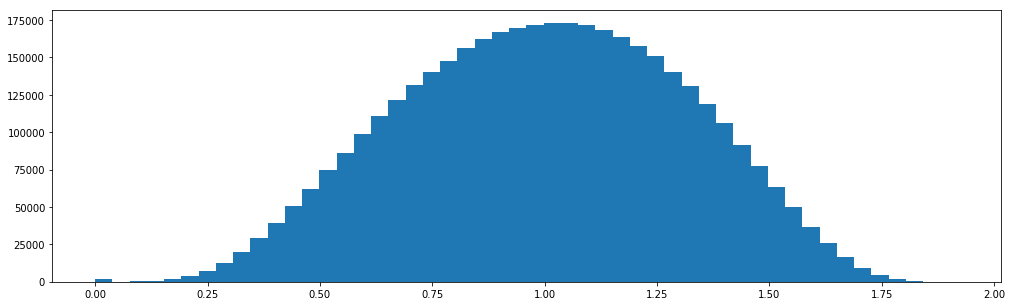

In [21]:
plt.hist(distances.reshape(-1), bins=50);

In [22]:
print('{} distances equal exactly zero.'.format(np.sum(distances == 0)))

2000 distances equal exactly zero.


Why are some distances equal to zero? **Your answer here.** The diagonal represents the distance from a track to itself and $d(u,u) = 0$. As there is 2000 tracks, there should be at least 2000 zeroes. Moreover, tracks 74348 and 86761 are duplicates (same song from same artist released in a different album) and thus share the same features vectors. Leaving aside numerical differencies, we should thus have two (due to symmetry) additional zeroes.

In [23]:
features.loc[74348].equals(features.loc[86761])

True

### 3.2 Weighted adjacency matrix

From our distances, we want to compute edge weights. If the distance is short, which means the tracks are similar, we want a strong edge. The most widespread kernel for that task is the Gaussian kernel, defined as
$$\mathbf{W}(u,v) = \exp \left( \frac{-d^2(u, v)}{\sigma^2} \right),$$
where $\sigma$ is a parameter which controls the width of the kernel.

Bonus. Can you think of another suitable kernel? **Your answer here.** 

The role of the kernel is to transform a distance to a similarity measure which will weight the edges of our graph. As such, the kernel should be positive and monotonically decreasing with respect to the distance. It should take its maximum value when the distance is zero, and tend to zero when the distance increases. Note that distances are non-negative by definition. So any funtion $f : \mathbb{R}^+ \rightarrow [0,C]$ that verifies $f(0)=C$ and $\lim_{x \rightarrow +\infty}f(x)=0$ and is strictly decreasing should be adapted. How fit a kernel is to a problem should be empirically tested.

Some examples:
* A simple linear kernel $\mathbf{W}(u,v) = \frac{d_{max} - d(u, v)}{d_{max} - d_{min}}$. As the cosine distance is bounded by $[0,2]$, a suitable linear kernel for it would be $\mathbf{W}(u,v) = 1 - d(u,v)/2$. In general, this kernel is however sensitive to outliers.
* A triangular kernel: a straight line between the points $(0,1)$ and $(t_0,0)$, and equal to 0 after this point.
* The logistic kernel $\left(e^{d(u,v)} + 2 + e^{-d(u,v)} \right)^{-1}$.
* An inverse function $(\epsilon+d(u,v))^{-n}$, with $n \in \mathbb{N}^{+*}$ and $\epsilon \in \mathbb{R}^+$.
* You can find some more [here](https://en.wikipedia.org/wiki/Kernel_%28statistics%29).

Compute below the weight of each edge.

Hints:
* At first, you can set the kernel width, $\sigma$, to the mean value of the distance. (It will preserve the distribution of distances.)
* Don't forget to set the diagonal to zero! We don't want self-connections.

In [24]:
kernel_width = distances.mean()
weights = np.exp(-distances**2 / kernel_width**2)

np.fill_diagonal(weights, 0)

So we just created a fully connected graph. For our algorithms to be more efficient, we want to sparsify it. There are two main ways to sparsify a graph: i) thresholding all the weights smaller than an $\epsilon$, and ii) keep the $k$ strongest edges for each node. Implement below the second option. You can start with $k=100$.

Hints:
* You can use `np.argsort` to sort the weights.
* Be sure that your weight matrix stays symmetric.
* Look at both the sparsity pattern and the weight distribution as an indication of correctness.

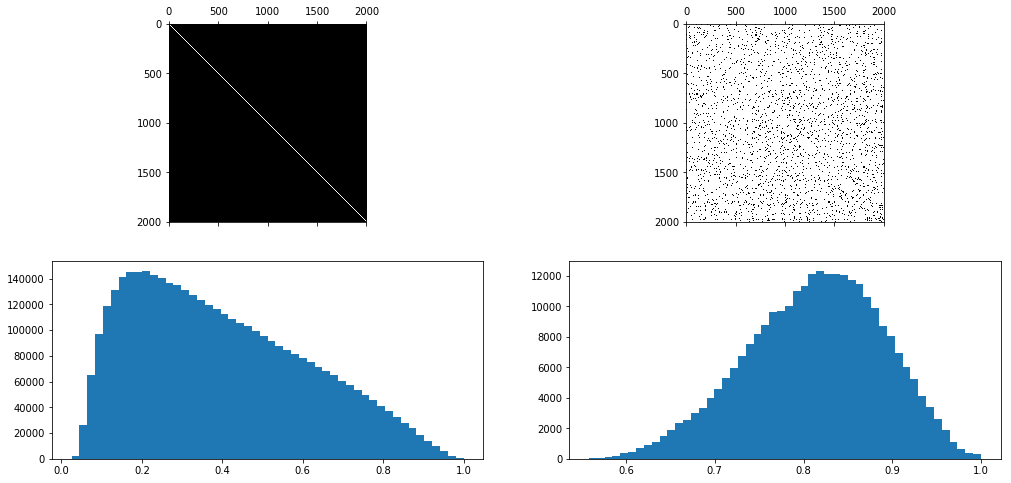

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(17, 8))
def plot(weights, axes):
    axes[0].spy(weights)
    axes[1].hist(weights[weights > 0].reshape(-1), bins=50);
plot(weights, axes[:, 0])

NEIGHBORS = 100

# Alternative:
# indices = np.argpartition(weights, -NEIGHBORS, axis=1)[:, :-NEIGHBORS]
# weights[np.arange(weights.shape[0])[:, None], indices] = 0
# weights = np.maximum(weights, weights.T)

# Alternative:
# mask = weights < np.sort(weights, axis=1)[:, -NEIGHBORS]
# weights[mask & mask.T] = 0

partition = np.argpartition(weights, -NEIGHBORS, axis=1)
maximum = weights[np.arange(weights.shape[0]), partition[:, -NEIGHBORS]]
mask = weights < maximum
weights[mask & mask.T] = 0

# Epsilon graph. Not good because not connected.
# epsilon = np.percentile(weights, 80)
# weights[weights < epsilon] = 0

# A correct implementation should pass the below tests.
assert np.all(weights == weights.T)
assert np.all(np.count_nonzero(weights, 0) >= NEIGHBORS)

plot(weights, axes[:, 1])

In [26]:
# Saving the graph for the fourth assignment.
w = sparse.csr_matrix(weights)
sparse.save_npz('../data/fma_graph.npz', w)

### 3.3 Bonus: visualize the adjacency matrix

Can you think of a way to observe if the two genres form clusters in the graph we created? You should only use the weight matrix `weights` and the genre labels `tracks['genre']`.

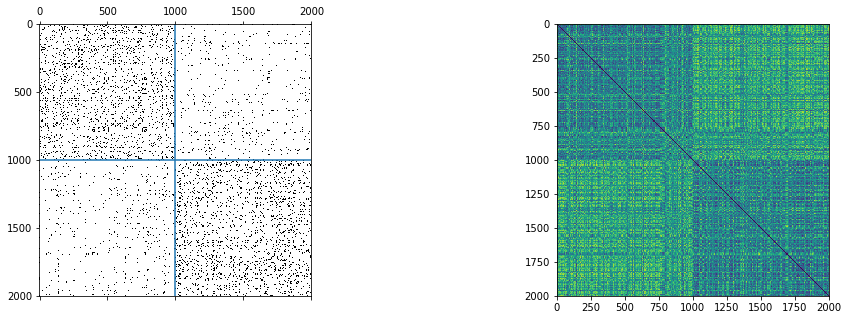

In [27]:
indices = np.argsort(tracks['genre'])

tracks = tracks.iloc[indices]
features = features.iloc[indices]
weights = weights[indices, :][:, indices]
distances = distances[indices, :][:, indices]

fig, axes = plt.subplots(1, 2)
axes[0].spy(weights)
axes[1].imshow(distances)

line = mpl.lines.Line2D((1000, 1000), (0, 2000))
axes[0].add_line(line)
line = mpl.lines.Line2D((0, 2000), (1000, 1000))
axes[0].add_line(line);

It is clear from the above matrices that there is more connections (or shorter distances) between tracks from the same genre than across genres.

### 3.4 Degrees

Compute below the degree vector.

Hints:
* Again, looking at the degree distribution will help you identify any mistake.

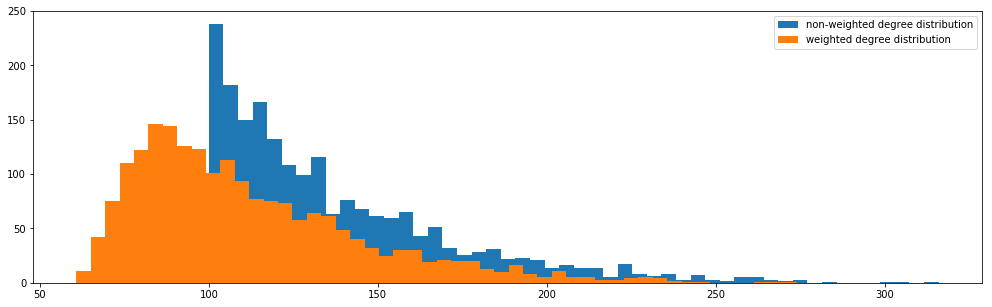

In [28]:
degrees = weights.sum(0)

plt.hist(np.count_nonzero(weights, 0), bins=50, label='non-weighted degree distribution')
plt.hist(degrees, bins=50, label='weighted degree distribution')
plt.legend();

### 3.5 Graph Laplacian

We will later need the Fiedler vector. Shall we compute the combinatorial or the normalized Laplacian? **Your answer here.**
Both choices are valid. Clustering with the sign of the Fiedler vector of the combinatorial Laplacian is a relaxation of the RatioCut. A relaxation of the NormalizedCut is obtained with the normalized Laplacian. The RatioCut is normalized by the number of nodes in the clusters which we wish to separate. The NormalizedCut is normalized by the volume of the cluster, which is the sum of degrees. Both normalizations of the MinCut seek to balance the clusters. For example we'd like to avoid separating one node from the rest of the graph. Both methods are viable in our case as we know that the nodes are perfectly balanced between the two genres.
In practice, the normalized Laplacian is often preferred. In Luxburg's "A tutorial on spectral clustering", it is claimed that it is preferable to use the normalized Laplacian in case of a broad degree distribution.
In the end, the choice of Laplacian is task-dependent: think of your end goal. If you value clustering, choose the one who gives you the better clusters. If you value visualization, choose the one who gives a better visual representation of the data at hand. In our case, the normalized Laplacian does better (from my point-of-view).

Implement your choice below. 

Hints:
* Compare the sparsity pattern of the Laplacian to the one of the weight matrix.

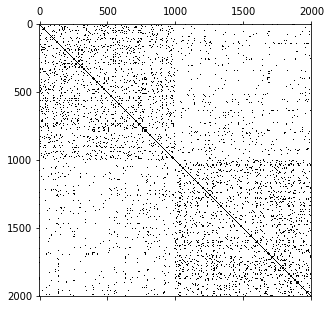

In [29]:
# Combinatorial Laplacian.
laplacian = np.diag(degrees) - weights

# Normalized Laplacian.
deg_inv = np.diag(1 / np.sqrt(degrees))
laplacian = deg_inv @ laplacian @ deg_inv

# Alternatively:
# laplacian = np.identity(weights.shape[0]) - deg_inv @ weights @ deg_inv

plt.spy(laplacian);

For efficient storage and computation, we can store this sparse matrix in a [compressed sparse row (CSR)](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29) format.

In [30]:
laplacian = sparse.csr_matrix(laplacian)

Compute the number of remaining edges in the graph.

In [31]:
n_edges = (laplacian.nnz - laplacian.shape[0]) // 2
print('{} edges out of {} x {} = {} ({:.2%})'.format(n_edges, *weights.shape, weights.size, n_edges/weights.size))
max_edges = NEIGHBORS * len(weights)
print('Our kNN construction allows between {:d} and {:d} edges'.format(max_edges//2, max_edges))

137495 edges out of 2000 x 2000 = 4000000 (3.44%)
Our kNN construction allows between 100000 and 200000 edges


## 4 Eigendecomposition of the graph Laplacian

The whole point of spectral graph theory is to compute the eigendecomposition of the Laplacian. We however don't need the full eigendecomposition (a.k.a. the graph Fourier basis) here. Compute the 10 eigenvectors with the smallest eigenvalues with one of the following functions: `np.linalg.eig`, `np.linalg.eigh`, `sparse.linalg.eigs`, `sparse.linalg.eigsh`. Justify your choice.

**Your answer here.** The matrix is Hermitian (real symmetric) and sparse, so we can use `eigsh`. As we only need a few eigenvectors, using the implicitly restarted Lanczos method (a variant of the power method) is efficient.
To find the 10 smallest eigenvalues, we can pass `which='SM'` (SM: smallest in magnitude) to the method. As the Laplacian's eigenvalues are non-negative, `which='SA'` (smallest algebraic) should give the same answers, albeit the used algorithm is often slower.
The alternative is to use ARPACK's *shift-invert* mode. This mode allows quick determination of non-external eigenvalues. (It involves transforming the eigenvalue problem to an equivalent problem with different eigenvalues.) In this case, we hope to find eigenvalues near zero, so we can set `sigma = 0`.
While it is said that ARPACK is not quite adept to find small eignevalues, I found that the shift-invert mode was actually slower in our case. (You can measure execution time with the IPython's [magic command](https://ipython.readthedocs.io/en/stable/interactive/magics.html) `%timeit`.)

In [32]:
eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian, k=10, which='SM')

# Alternative (actually slower):
# eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian, k=10, sigma=0)

# That's much slower:
# eigenvalues, eigenvectors = np.linalg.eigh(laplacian.toarray())

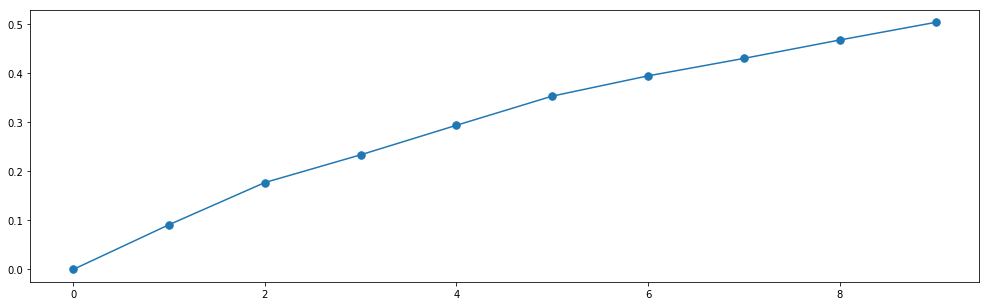

In [33]:
plt.plot(eigenvalues, '.-', markersize=15);

Why can we diagonalize the graph Laplacian in the first place? **Your answer here.** Because the Laplacian is a symmetric real matrix by construction. See the [spectral theorem](https://en.wikipedia.org/wiki/Spectral_theorem). (More details [here](https://www.math.wustl.edu/~freiwald/309orthogdiag.pdf).)

Why are all the eigenvalues real? **Your answer here.** The spectral theorem, again.

Why are all the eigenvalues non-negative? **Your answer here.** Because the Laplacian is a [positive semi-definite matrix (PSD)](https://en.wikipedia.org/wiki/Positive-definite_matrix#Positive_semidefinite). We can indeed write
$$
\newcommand{\x}{\mathbf{x}}
\newcommand{\L}{\mathbf{L}}
\newcommand{\W}{\mathbf{W}}
\x^\intercal \L \x = \sum_{i \sim j} \W_{ij} (x_i - x_j)^2 \geq 0.
$$

### 4.1 Connectedness

Is the graph connected? Justify. Knowing how we built the graph, can we ensure it is connected?

In [34]:
print(eigenvalues)

[ -1.39946784e-17   9.11776280e-02   1.77083008e-01   2.33602346e-01
   2.93844433e-01   3.53280956e-01   3.94569399e-01   4.30145342e-01
   4.67632320e-01   5.03605782e-01]


**Your answer here.** The graph is connected because only one eigenvalue equals zero (eigenvalue zero has a multiplicity of one). While the kNN construction assures that each node is connected to at least $k$ other nodes, it won't force the graph to be connected. If our Rock and Hip-Hop songs would form very distinct clusters, the graph may not be connected.
Connection can only be ensured if $NEIGHBORS > \frac{|G|}{2}$ (this graph would not be sparse at all).

Note that the number of connected components is the dimension of the nullspace of $L$, and that the corresponding eigenvectors form a basis of this null space. These eigenvectors are indicator vectors of the connected components. Clustering is straighforward if the clusters are disconnected!

### 4.2 Eigenvector question

What do you expect as the result of the below computation? Justify. Do you get the value you expected? If not, why?

Note that `x @ y` (introduced in Python 3.5) is equivalent to `np.matmul(x, y)`. You should prefer the former as it makes it easier to read formulas.

In [35]:
np.sum(laplacian @ (2 * eigenvectors[:, 0]))

-3.6572849783367278e-16

**Your answer here.** We expect zero because the first eigenvalue is zero. As such, the first eigenvector lies in the null-space of the Laplacian. The small error is due to numerical precision (finite representation of real numbers, accuracy of the eigendecomposition).

## 5 Visualization and clustering

Finally, let's use the data and graph we prepared. When [exploring data](https://en.wikipedia.org/wiki/Exploratory_data_analysis), it's often useful to visualize an entire dataset. Because for us humans it's hard to look at data in 140 dimensions, we need to somehow reduce the dimensionality to 2 or 3 and visualize the data in this more familiar space. While such a reduction will obviously be destructive, many algorithms have been developed to preserve certain properties.

### 5.1 Principal component analysis (PCA)

[PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) is a standard algorithm to reduce the dimensionality of a dataset. It computes the axes of principal variance and project the data on them. It does only use the features we computed, not the graph. We show it here for comparison. (We use [scikit-learn](http://scikit-learn.org), a very convenient library for Machine Learning.)

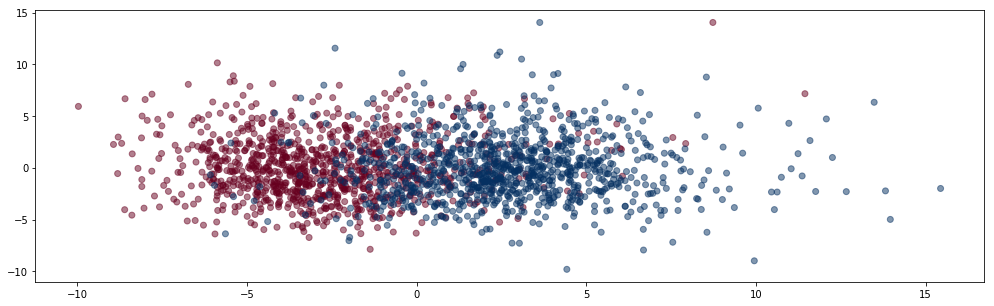

In [36]:
features_pca = decomposition.PCA(n_components=2).fit_transform(features)
genres = preprocessing.LabelEncoder().fit_transform(tracks['genre'])
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=genres, cmap='RdBu', alpha=0.5);

### 5.2 Graph embedding

Instead of using the features directly, we can try to visualize our similarity graph. That graph is embedded in an ambiant space of 140 dimensions (the number of features, that is the number of MFCCs times the number of summary statistics) at first, i.e. each node has a position in an 140-dimensional Euclidean space. Because we cannot visualize such an high-dimensional space, we want to embed the graph in a 2D space.

One way to embed a graph is to use the value of the eigenvectors as coordinates. For the below plot, use the value of the second eigenvector as the x coordinate of a node, and the value of the third eigenvector as the y coordinate. The color is indicated by the genre.

Why don't we use the first eigenvector? **Your answer here.** Because it is not informative w.r.t. genres. The first eigenvector is $\frac{1}{N} \mathbf{1}$ for the combinatorial Laplacian and $\mathbf{D}^{1/2} \mathbf{1}$ for the normalized Laplacian, where $\mathbf{1}$ is the vector of all ones. As such, it is either constant, either a sole indication of the degree.

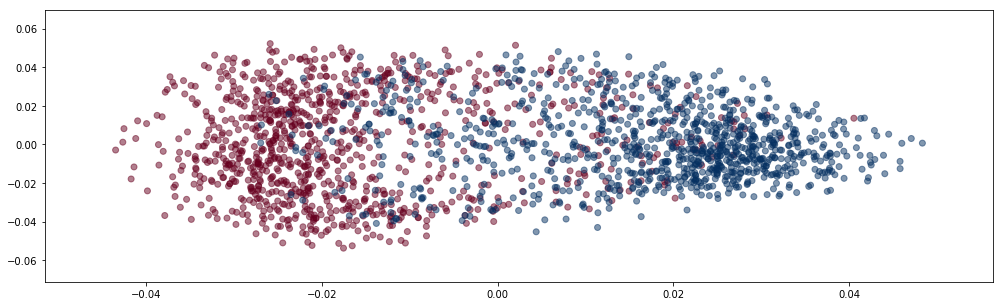

In [37]:
x = eigenvectors[:, 1]
y = eigenvectors[:, 2]
plt.scatter(x, y, c=genres, cmap='RdBu', alpha=0.5);

See how well this plot summarizes 2GB of data and 2000 tracks! We could now design a playlist generator as a random walk on this similarity graph and visualize its trajectory as it hops from track to track. :)

### 5.3 Clustering

Note how we did not try to build a machine to recognize the musical genre given a track (that would have been a [classification problem](https://en.wikipedia.org/wiki/Statistical_classification)). We did merely try to visualize the data, by means of PCA and a graph embedding algorithm. What does it tell us that genre clearly appears in our visualization?

**Your answer here.**
At first, it means that the data in our high dimensional feature space lies on an intrinsic low dimensional manifold, such as we can meaningfully visualize it in 2 dimensions.
At a higher level, it can tell us that genres are useful to categorize songs and organize music collections. Or that the chosen features are (overly?) sensitive to musical genre. Or that I overfitted it to genre recognition while designing the assignment. Beware the pitfalls!

As such, we can try to cluster the tracks with the Fiedler vector, and look if the (unsupervised) clustering agrees with the *ground truth* genre categorization. Reproduce below the above scatter plot, but with the sign of the Fiedler vector as the color instead of the genre.

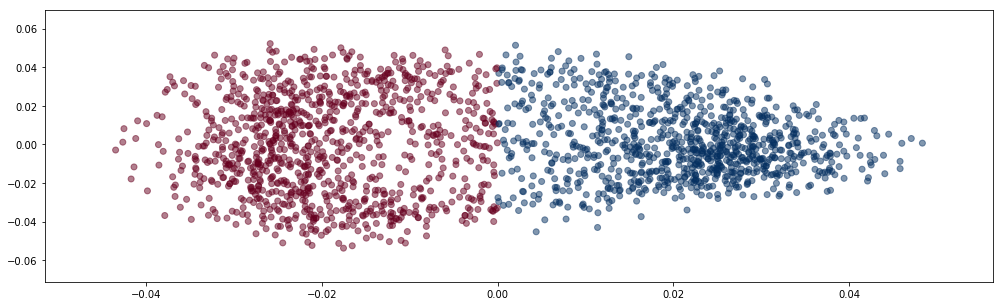

In [38]:
labels = (eigenvectors[:, 1] > 0)

plt.scatter(x, y, c=labels, cmap='RdBu', alpha=0.5);

### 5.4 Error rate

How many tracks were wrongly categorized by the Fiedler vector, according to the Rock / Hip-Hop ground truth?

In [39]:
err = np.count_nonzero(labels - genres)
err = err if err < len(labels) / 2 else len(labels) - err
print('{} errors ({:.2%})'.format(err, err/len(labels)))

294 errors (14.70%)


Tune some parameters (e.g. `kernel_width`, `NEIGHBORS`), discard some features (section 2.4), change the distance metric (section 3.1) to get less errors. You should get an error rate below 15% (i.e. less than 300 errors in total). Try to understand the effect of each parameter. After data cleaning, parameter tuning is the other dirty work of a data scientist! Be aware that tuning the parameters on a specific dataset will lead to [overfitting](https://en.wikipedia.org/wiki/Overfitting).

## 6 Conclusion

Among other things, this assignment showed us that a graph can be useful for e.g. visualization or clustering, even when there is none in the original data. One of the design goal of this assignment, while dealing with real data, was to follow the complete Data Science process, from data acquisition to interpretation of the results. The exploitation of the data showed us that a machine can discern musical genres by looking at pairwise distances between spectral features extracted from audio recordings.

### 6.1 Bonus

What is the name of the technique we used to visualize the data in the last two plots? What does it try to preserve when reducing the dimensionality (of the ambiant space) from 140 to 2?

**Your answer here.** The technique is named Laplacian eigenmaps and has been introduced by Belkin and Niyogi in their paper [Laplacian Eigenmaps for Dimensionality Reduction and Data](http://web.cse.ohio-state.edu/~belkin.8/papers/LEM_NC_03.pdf). The algorithm tries to preserve the similarity between data samples as follows:
$$
\newcommand{\x}{\mathbf{x}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\Y}{\mathbf{Y}}
\newcommand{\L}{\mathbf{L}}
\newcommand{\D}{\mathbf{D}}
\newcommand{\I}{\mathbf{I}}
\arg\min_{\y_1,\ldots,\y_N}\sum_{i\sim j}w_{ij}\|\y_i - \y_j\|_2^2
= \arg\min_{\Y \in \mathbb{R}^{N \times P}}
\operatorname{tr}(\Y^\intercal \L \Y) \text{ , s.t. } \Y^\intercal \Y = \I,
$$
where $\y_i$ is the coordinate vector in the $P$-dimensional space of the $i$-th data point.
It requires that $\y_i$ and $\y_j$ are close together if the corresponding data points $\x_i$ and $\x_j$ are strongly connected, i.e. their similarity $w_{ij}$ is large. It turns out, as seen in class, that the solution to this problem is given by the eigenvectors of the graph Laplacian.